# Compare the test results

In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
%matplotlib inline

In [4]:
%pwd

'/home/dominic/llm-quantization-study-thesis'

In [5]:
%ls

benchmark_w2.png                      quantization_methods/
convert_models.ipynb                  quantized/
eval_results.ipynb                    QuaRot_vs_baseline.png
install-miniconda.sh                  README.md
llm-quantization-study-thesis/        results/
lm-eval-tasks.txt                     scripts/
lm-evaluation-harness/                size_comparison.png
model_size.png                        ternary_quarot.png
output.png                            ternary_QuaRot_vs_baseline.png
performance_test_native_dtypes.ipynb  ttft_latency.png
per_token_latency.png                 W2A16_benchmarks.png
prerequists/


In [20]:
# the model size in GB extracted from the performance_test_native_dtypes.ipynb
# models are in eval mode
# tokenizers are not considered
model_sizes = {
    #"Mistral-7B-v0_3-BF16": 30.065844224,
    #"Mistral-7B-v0_3-bitmat-ternary": 3.897303488,
    "Llama-2-7B-FP32": 26.953670912,
    #"QuaRot-Ternary-Llama-2-7B": 13.54721002,
    "BitMat-Llama-2-7B": 2.806358464
}

In [7]:
# performance provided in the The Era of 1-Bit LLMs paper
reported_paper_llm_performances = {
    "BitNet-158b-QAT-3.9B (reported)": {
        'arc_challenge': 0.287,
        'arc_easy': 0.642,
        'boolq': 0.635,
        'hellaswag': 0.442,
        'openbookqa': 0.242,
        'piqa': 0.732,
        'winogrande': 0.605,
    },
}

for model_name, metric_dict in reported_paper_llm_performances.items():
    metrics = metric_dict.values()
    reported_paper_llm_performances[model_name]["average"] = sum(metrics)/len(metrics)

print(reported_paper_llm_performances)

{'BitNet-158b-QAT-3.9B (reported)': {'arc_challenge': 0.287, 'arc_easy': 0.642, 'boolq': 0.635, 'hellaswag': 0.442, 'openbookqa': 0.242, 'piqa': 0.732, 'winogrande': 0.605, 'average': 0.5121428571428571}}


In [8]:
import math
# Step 1: Read all Json files
def read_json_file_performances(dir: str = "results"):
    json_files = {}
    for file in os.listdir(dir):
        split_name = file.split(".")
        file_extension = split_name.pop(-1)
        file_name = ".".join(split_name)
        
        if file_extension == "json":
            with open(f"{dir}/{file}") as j:
                raw = json.load(j)
                # extract the accuracy (acc,none) metric for all tasks
                task_perf = {}
                perplexity = None
                for bench, perf_block in raw["results"].items():
                    # this is how this block looks like:
                    #{'boolq': {'alias': 'boolq',
                    # 'acc,none': 0.8207951070336391,
                    # 'acc_stderr,none': 0.006707873297823241}}
                    if "acc,none" in perf_block.keys():
                        task_perf[bench] = perf_block["acc,none"]
                    elif "acc" in perf_block.keys():
                        task_perf[bench] = perf_block["acc"]
                    elif "byte_perplexity,none" in perf_block.keys():
                        perplexity = perf_block["byte_perplexity,none"]
                    elif "byte_perplexity" in perf_block.keys():
                        perplexity = perf_block["byte_perplexity"]
                    else:
                        print("No performance metric found for", bench)
                        task_perf[bench] = None
                
                # calculate average performance
                perfs = task_perf.values()
                print("Performances", perfs)
                perfs = [x for x in perfs if str(x) != "None"]
                average_perf = sum(perfs) / len(perfs)
                task_perf["average"] = average_perf
                
                task_perf["perplexity"] = perplexity

                json_files[file_name] = task_perf
    return json_files
            

json_files = read_json_file_performances()
json_files

Performances dict_values([0.43430034129692835, 0.7626262626262627, 0.7773700305810397, 0.5716988647679745, 0.780739934711643, 0.6921862667719021])
Performances dict_values([0.21075085324232082, 0.24873737373737373, 0.48303078137332284, 0.3782874617737003, 0.25721967735510853, 0.5233949945593036])


{'FP32-Llama-2-7B': {'arc_challenge': 0.43430034129692835,
  'arc_easy': 0.7626262626262627,
  'boolq': 0.7773700305810397,
  'hellaswag': 0.5716988647679745,
  'piqa': 0.780739934711643,
  'winogrande': 0.6921862667719021,
  'average': 0.6698202834592917,
  'perplexity': 1.5015830801242716},
 'QuaRot-Ternary-Llama-2-7B': {'arc_challenge': 0.21075085324232082,
  'arc_easy': 0.24873737373737373,
  'winogrande': 0.48303078137332284,
  'boolq': 0.3782874617737003,
  'hellaswag': 0.25721967735510853,
  'piqa': 0.5233949945593036,
  'average': 0.350236857006855,
  'perplexity': 11.53162876555606}}

In [9]:
# Step 2: Add the reported metrics from papers
def to_df(json_files: list, additional_performances: list = None):
    if additional_performances is not None:
        json_files.update(additional_performances)
    return pd.DataFrame(json_files)

#model_performances = to_df(json_files, reported_paper_llm_performances)
model_performances = to_df(json_files)

In [10]:
model_performances

,FP32-Llama-2-7B,QuaRot-Ternary-Llama-2-7B
arc_challenge,0.434300,0.210751
arc_easy,0.762626,0.248737
boolq,0.777370,0.378287
hellaswag,0.571699,0.257220
piqa,0.780740,0.523395
winogrande,0.692186,0.483031
average,0.669820,0.350237
perplexity,1.501583,11.531629


0.350236857006855
0.6698202834592917


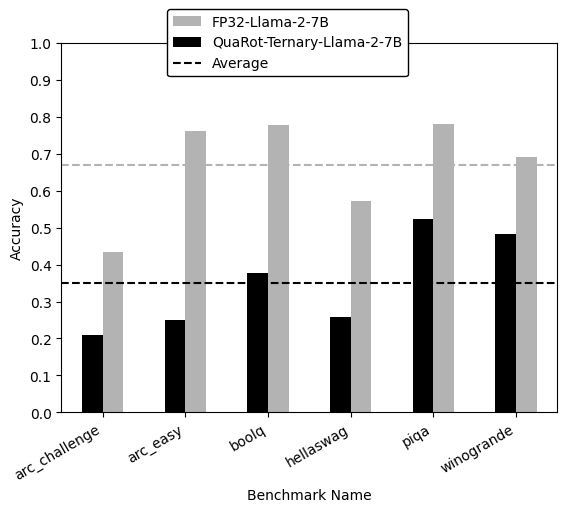

In [11]:
def plot_performances(model_performances, bbox_anchor: tuple = (0.14, 1), exclude: list = ["perplexity"]):
    model_performances = model_performances.drop(exclude)
    fig, ax = plt.subplots()
    color_map = plt.cm.gray(np.linspace(0,0.7,len(model_performances.columns)))
    sorted_col_names = [col for _, col in sorted(zip(model_performances.loc["average"], model_performances.columns))]

    for id, col_name in enumerate(sorted_col_names):
        avg = model_performances[col_name].loc["average"]
        print(avg)
        ax.axhline(avg, color=color_map[id], linestyle="--")

    example_line = ax.axhline(-1, color="black", linestyle="--")
    example_line.set_label("Average")

    model_performances = model_performances[sorted_col_names] #reorder the columns

    model_performances.iloc[0:-1].plot(ax=ax, kind="bar", stacked=False, ylim=(0, 1.0), ylabel="Accuracy", xlabel="Benchmark Name", color=color_map, legend=None)

    plt.xticks(rotation=30, ha="right")

    plt.yticks(np.linspace(0,1,11,endpoint=True))

    #fig.legend(loc="center left", bbox_to_anchor=(0.05, 0.95), ncol=2)
    
    # reverse the legend labels to represent the way their averages are displayed 
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc="center left", bbox_to_anchor=bbox_anchor, ncol=1, facecolor="white", framealpha=1, edgecolor="black")
    #fig.legend(loc="center left", bbox_to_anchor=(0.25, 0.9), ncol=1)

plot_performances(model_performances, bbox_anchor=(0.2, 1))

IDEA: Test if the performance decreases linearly with reduced bits or if there is a optimum

## Performance Difference of different 2-bit quantization approaches

In [12]:
w2a16_performances = read_json_file_performances("results/W2A16")
w2a16_df = to_df(w2a16_performances, reported_paper_llm_performances)
w2a16_df

Performances dict_values([0.23122866894197952, 0.2537878787878788, 0.5327217125382263, 0.2529376618203545, 0.5380848748639826, 0.49171270718232046])
Performances dict_values([0.21928327645051193, 0.2474747474747475, 0.44220183486238535, 0.2559251145190201, 0.5282916213275299, 0.4925019731649566])
Performances dict_values([0.5946681175190425, 0.6217125382262997, 0.37247474747474746, 0.197098976109215, 0.2949611631149173, 0.531965272296764])


,BitNet-158b-PTQ-Llama2-7B,QLLM-W2A16-Llama2-7B,QuaRot-W2A16-Llama2-7B,BitNet-158b-QAT-3.9B (reported)
arc_challenge,0.231229,0.219283,0.197099,0.287000
arc_easy,0.253788,0.247475,0.372475,0.642000
boolq,0.532722,0.442202,0.621713,0.635000
hellaswag,0.252938,0.255925,0.294961,0.442000
piqa,0.538085,0.528292,0.594668,0.732000
winogrande,0.491713,0.492502,0.531965,0.605000
average,0.383412,0.364280,0.435480,0.512143
perplexity,31588.097169,11.823064,2.285999,NaN
openbookqa,NaN,NaN,NaN,0.242000


0.36427976129985856
0.3834122506891237
0.4354801357901643
0.5121428571428571


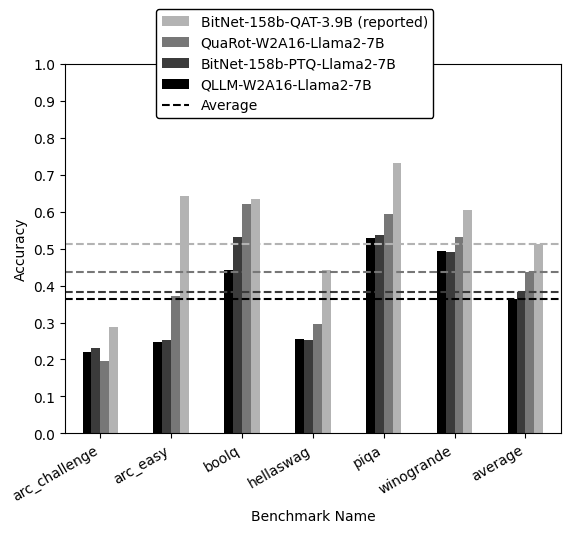

In [13]:
plot_performances(w2a16_df, bbox_anchor=(0.17,1))

## Understand the differences in model performance

In [16]:
def plot_metric_difference(model_metrics: dict, ylabel: str, title: str, font_size=20):
    plt.rcParams.update({'font.size': font_size})
    
    fig, ax = plt.subplots(layout='constrained')
    model_names = list(model_metrics.keys())

    ax.bar(model_names, model_metrics.values(), color="black", width=0.6)

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    #ax.set_ylim(0, 1.20)

    # Calculate the percentage difference
    percent_diff = ((model_metrics[model_names[0]] - model_metrics[model_names[1]]) / model_metrics[model_names[0]]) * 100

    if percent_diff > 0:
        # Add the arrow annotation
        x_start = 0.4  # X position of the first bar
        x_end = x_start + 0.4    # X position of the second bar
        y_start = model_metrics[model_names[0]]
        y_end = model_metrics[model_names[1]]

    elif percent_diff < 0:
        # Add the arrow annotation
        x_start = 0.25  # X position of the first bar
        x_end = x_start + 0.4    # X position of the second bar
        y_start = model_metrics[model_names[0]]
        y_end = model_metrics[model_names[1]]

    # Draw arrow and text
    ax.annotate(
        "",
        xy=(x_end, y_end),       # Arrow endpoint (top of second bar)
        xytext=(x_start, y_start),  # Arrow start point (top of first bar)
        arrowprops=dict(facecolor='black', shrink=0.03, width=3.5, headwidth=8, headlength=10),
        ha='center', va='bottom'
    )

    text_offset = 0.2 if percent_diff >= 0 else -0.2

    ax.annotate(
        f'{abs(percent_diff):.1f}%',  # Text showing the percentage difference
        xy=(x_start, y_start),
        xytext=((x_end+x_start)/2+text_offset, (y_end + y_start)/2),
        ha='center', va='bottom'
    )

    # calculate differences
    original_times = model_metrics[model_names[0]] / model_metrics[model_names[1]]
    reverse_times = model_metrics[model_names[1]] / model_metrics[model_names[0]]
    #performance_times = model_performances["Mistral-7B-v0_3-BF16"]["average"] / model_performances["Bitmat-Absmean-Mistral-v0_3"]["average"]
    print(f"The full precision model is '{round(original_times, 2)}' times bigger/slower than the quantized model and the quantized model is '{round(reverse_times, 2)}' times bigger/slower than the original model.")

    fig.show()

The full precision model is '9.6' times bigger/slower than the quantized model and the quantized model is '0.1' times bigger/slower than the original model.


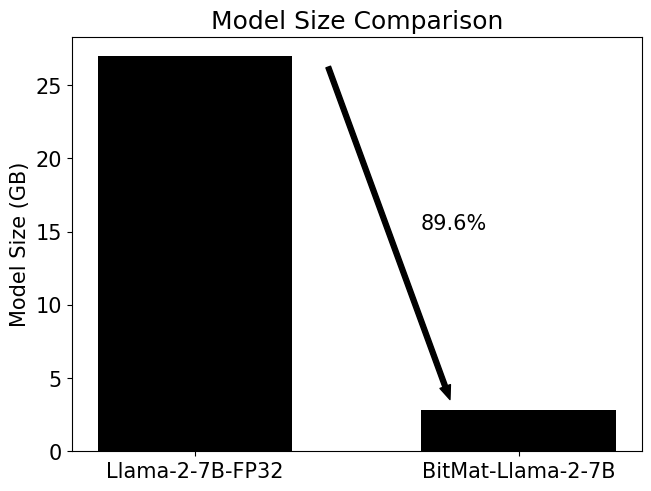

In [21]:
plot_metric_difference(model_sizes, 'Model Size (GB)', 'Model Size Comparison', font_size=15)

### Plot the Latency differences

In [22]:
latency_per_token = {
    "Llama-2-7B-FP32": 52.90, 
    #"Llama-2-7B-ternary": 268.40, 
    "QuaRot-Ternary-Llama-2-7B": 26.644336700439453}
latency_ttft = {
    "Llama-2-7B-FP32": 46.63, 
    #"Llama-2-7B-ternary": 65.86, 
    "QuaRot-Ternary-Llama-2-7B": 24.38755226135254}

The full precision model is '1.91' times bigger/slower than the quantized model and the quantized model is '0.52' times bigger/slower than the original model.


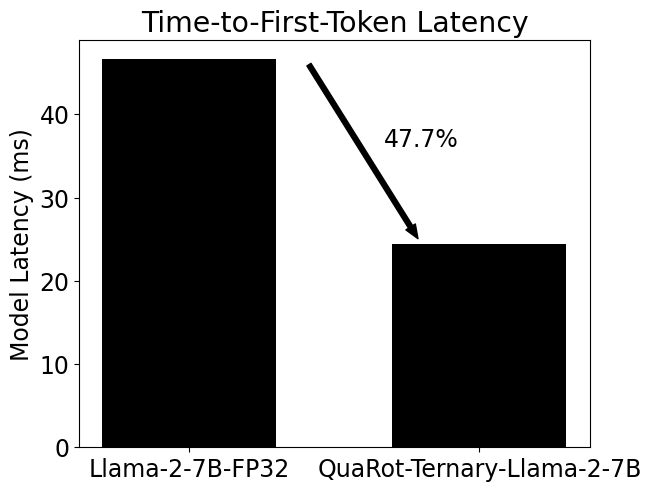

In [26]:
plot_metric_difference(latency_ttft, 'Model Latency (ms)', 'Time-to-First-Token Latency', font_size=17)

The full precision model is '1.99' times bigger/slower than the quantized model and the quantized model is '0.5' times bigger/slower than the original model.


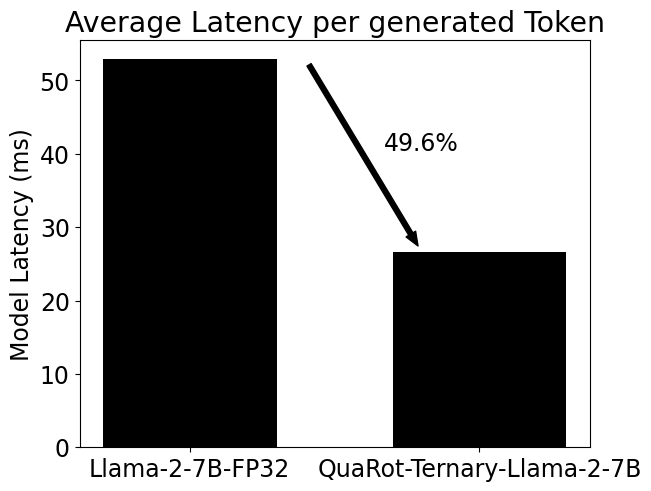

In [28]:
plot_metric_difference(latency_per_token, 'Model Latency (ms)', 'Average Latency per generated Token', font_size=17)

In [51]:
perplexities = model_performances.loc["perplexity"].to_dict()

In [52]:
perplexities

{'FP32-Llama-2-7B': 1.5015830801242716,
 'BitNet-158b-PTQ-Llama2-7B': 31588.097169344685,
 'QuaRot-Ternary-Llama-2-7B': 11.53162876555606,
 'QLLM-W2A16-Llama2-7B': 11.823063835102788,
 'QuaRot-W2A16-Llama2-7B': 2.285998608449343}

In [53]:
{ k:'{:.2e}'.format(v) for k,v in perplexities.items()}

{'FP32-Llama-2-7B': '1.50e+00',
 'BitNet-158b-PTQ-Llama2-7B': '3.16e+04',
 'QuaRot-Ternary-Llama-2-7B': '1.15e+01',
 'QLLM-W2A16-Llama2-7B': '1.18e+01',
 'QuaRot-W2A16-Llama2-7B': '2.29e+00'}

In [57]:
degradation = {k:str((perplexities["FP32-Llama-2-7B"]/v)*100) + "%" for k,v in perplexities.items()}
degradation

{'FP32-Llama-2-7B': '100.0%',
 'BitNet-158b-PTQ-Llama2-7B': '0.004753635751068645%',
 'QuaRot-Ternary-Llama-2-7B': '13.021430976076557%',
 'QLLM-W2A16-Llama2-7B': '12.70045650659567%',
 'QuaRot-W2A16-Llama2-7B': '65.68608898422897%'}